# MERFISH DE

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [3]:
gene =    anndata.read_h5ad("../cell_ranger_annotation/merfish.h5ad")

Transforming to str index.


In [4]:
gene

AnnData object with n_obs × n_vars = 243799 × 254 
    obs: 'label', 'subclass', 'sampleID', 'sliceID', 'label_v1', 'AP_distance (um)', 'pos_x (um)', 'pos_y (um)', 'cell_id'
    var: 'n_iso'
    layers: 'X', 'log1p', 'norm'

In [6]:
gene = gene[:,gene.var.sort_index().index]

In [8]:
print(gene.shape)

(243799, 254)


In [9]:
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp, ttest_ind
import numpy as np
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')



def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def correct_pval(pval, method):
    nfeat = pval.shape[1]
    
    if method == 'benjamini-hochberg':
        _, pval_corr, _, _ = multipletests(pval, alpha=0.01, method='fdr_bh')
    elif method == 'bonferroni':
        pval_corr = np.minimum(pval * nfeat, 1.0)
        
    return pval_corr

def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)

    for tidx, t in enumerate(unique):
        logging.debug("{} of {} assignments: {}".format(tidx+1, nuniq, t))
        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)
        
        pvalue = np.nan
        statistic = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        t_mat = t_mat[:, mask]
        c_mat = c_mat[:, mask]
        # added

        # added
        if mask.sum()>0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate", equal_var=False)
            pvalue = test.pvalue
            statistic = test.statistic
                
        pval[tidx,:][mask] = pvalue
        stat[tidx,:][mask] = statistic
    
    return (pval, stat)

In [11]:
%%time
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
gene_features = gene.var.index.values
assignments   = gene.obs.subclass.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_gene_raw, stat = dexpress(mat, components, gene_features, assignments, 
                      nan_cutoff=nan_cutoff)

p_gene = correct_pval(p_gene_raw/2, corr_method)
s_gene = stat

04-Mar-20 21:36:00 - 1 of 26 assignments: Astrocytes
04-Mar-20 21:36:00 - 2 of 26 assignments: Endothelial
04-Mar-20 21:36:00 - 3 of 26 assignments: Ependymal
04-Mar-20 21:36:01 - 4 of 26 assignments: L2/3_IT
04-Mar-20 21:36:01 - 5 of 26 assignments: L4/5_IT
04-Mar-20 21:36:01 - 6 of 26 assignments: L56_NP
04-Mar-20 21:36:01 - 7 of 26 assignments: L5_IT
04-Mar-20 21:36:02 - 8 of 26 assignments: L5_PT
04-Mar-20 21:36:02 - 9 of 26 assignments: L6_CT
04-Mar-20 21:36:02 - 10 of 26 assignments: L6_IT
04-Mar-20 21:36:03 - 11 of 26 assignments: L6_IT_Car3
04-Mar-20 21:36:03 - 12 of 26 assignments: L6b
04-Mar-20 21:36:03 - 13 of 26 assignments: Lamp5
04-Mar-20 21:36:03 - 14 of 26 assignments: Macrophages
04-Mar-20 21:36:04 - 15 of 26 assignments: Microglia
04-Mar-20 21:36:04 - 16 of 26 assignments: OPC
04-Mar-20 21:36:04 - 17 of 26 assignments: Oligodendrocytes
04-Mar-20 21:36:04 - 18 of 26 assignments: Pericytes
04-Mar-20 21:36:05 - 19 of 26 assignments: Pvalb
04-Mar-20 21:36:05 - 20 of 26 as

CPU times: user 4.23 s, sys: 3.39 s, total: 7.62 s
Wall time: 7.61 s


In [12]:
p1 = p_gene
s1 = stat

In [13]:
alpha = 0.01
tcrit = 0


bool_mask = np.ones(p1.shape, dtype=bool)

p1_mask = np.logical_and(p1<alpha, s1>tcrit)

bool_mask = p1_mask

In [14]:
bool_mask.sum()

431

In [15]:
assignments = gene.obs.subclass.values
unique = np.unique(assignments)

In [16]:
unique

array(['Astrocytes', 'Endothelial', 'Ependymal', 'L2/3_IT', 'L4/5_IT',
       'L56_NP', 'L5_IT', 'L5_PT', 'L6_CT', 'L6_IT', 'L6_IT_Car3', 'L6b',
       'Lamp5', 'Macrophages', 'Microglia', 'OPC', 'Oligodendrocytes',
       'Pericytes', 'Pvalb', 'SMC', 'Sncg', 'Sst', 'Sst_Chodl', 'VLMC',
       'Vip', 'striatum'], dtype=object)

In [19]:
markers_gene = pd.DataFrame(index=unique, columns=["gene_name", "p_raw", "p_bonferroni"])

In [22]:
gene_features = gene.var.index.values

for uidx, u in enumerate(unique):
    mask = bool_mask[uidx] # np.logical_and(bool_mask[uidx], bool_mask.sum(axis=0)==1)
    
    p = p_gene[uidx][mask]
    p_raw = p_gene_raw[uidx][mask]
    
    psort = np.argsort(p)
    
    fsorted = gene_features[mask][psort]
    psorted = p[psort]
    p_raw_sorted = p_raw[psort]
    
    markers_gene.loc[u]["gene_name"] = fsorted
    markers_gene.loc[u]["p_raw"] = p_raw_sorted
    markers_gene.loc[u]["p_bonferroni"] = psorted

In [23]:
markers_gene

,gene_name,p_raw,p_bonferroni
Astrocytes,"[Aqp4, Cxcl14, Daam2, Pou3f3, Timp3]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
Endothelial,"[Cldn5, Flt1, Ptprm, Calb1, Vip]","[0.0, 0.0, 0.0, 8.951229453535627e-62, 7.96263...","[0.0, 0.0, 0.0, 1.1368061405990247e-59, 0.0010..."
Ependymal,"[Igf2, Fam84b, Sulf1, Timp3, Crhr2, Cobll1, Ph...","[1.1034073872148323e-54, 1.2188585818917105e-4...","[1.401327381762837e-52, 1.5479503990024722e-44..."
L2/3_IT,"[C1ql3, Syndig1, Slc30a3, Slc17a7, Sertm1, Sat...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
L4/5_IT,"[Cdh12, Unc5d, Syndig1, Slc30a3, Slc17a7, Satb...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
L56_NP,"[Bcl11b, Tshz2, Trp53i11, Tox, Sulf2, Spon1, S...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
L5_IT,"[Cdh12, Tenm3, Tac2, Syndig1, Sulf2, St6galnac...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
L5_PT,"[Ano4, Tmem163, Syndig1, Sulf2, Spon1, Slc17a7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
L6_CT,"[Ano4, Tac2, Syt6, Slc17a7, Sema5a, Satb2, Rnf...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
L6_IT,"[Bcl11b, Tenm3, Tac2, Syndig1, Slc30a3, Slc17a...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [25]:
gene.obs.subclass.value_counts()

L2/3_IT             33757
L4/5_IT             29147
L6_CT               23878
Oligodendrocytes    19472
Astrocytes          19230
Endothelial         18183
L5_IT               14685
L6_IT               12475
Microglia            8554
Pvalb                7885
L5_PT                6759
Pericytes            6553
VLMC                 6173
Macrophages          5133
OPC                  4906
Sst                  4853
SMC                  3785
L6b                  3487
L56_NP               3482
striatum             3214
Lamp5                3095
Vip                  2789
L6_IT_Car3           1563
Sncg                  477
Sst_Chodl             232
Ependymal              32
Name: subclass, dtype: int64

In [31]:
[i  for i in markers_gene.loc['L2/3_IT']["gene_name"]]

['C1ql3',
 'Syndig1',
 'Slc30a3',
 'Slc17a7',
 'Sertm1',
 'Satb2',
 'Rgs6',
 'Rab3b',
 'Ptprt',
 'Ptprk',
 'Prdm8',
 'Pou3f3',
 'Penk',
 'Meis2',
 'Lamp5',
 'Igfbp5',
 'Dscaml1',
 'Cux2',
 'Calb1',
 'Unc5d',
 'Wipf3',
 'Gad2']

In [32]:
specific_cluster = "L2/3_IT"
specific_gene = "C1ql3"

In [33]:
specific_gene

'C1ql3'

04-Mar-20 21:44:40 - update_title_pos
04-Mar-20 21:44:40 - update_title_pos
04-Mar-20 21:44:40 - update_title_pos
04-Mar-20 21:44:40 - update_title_pos


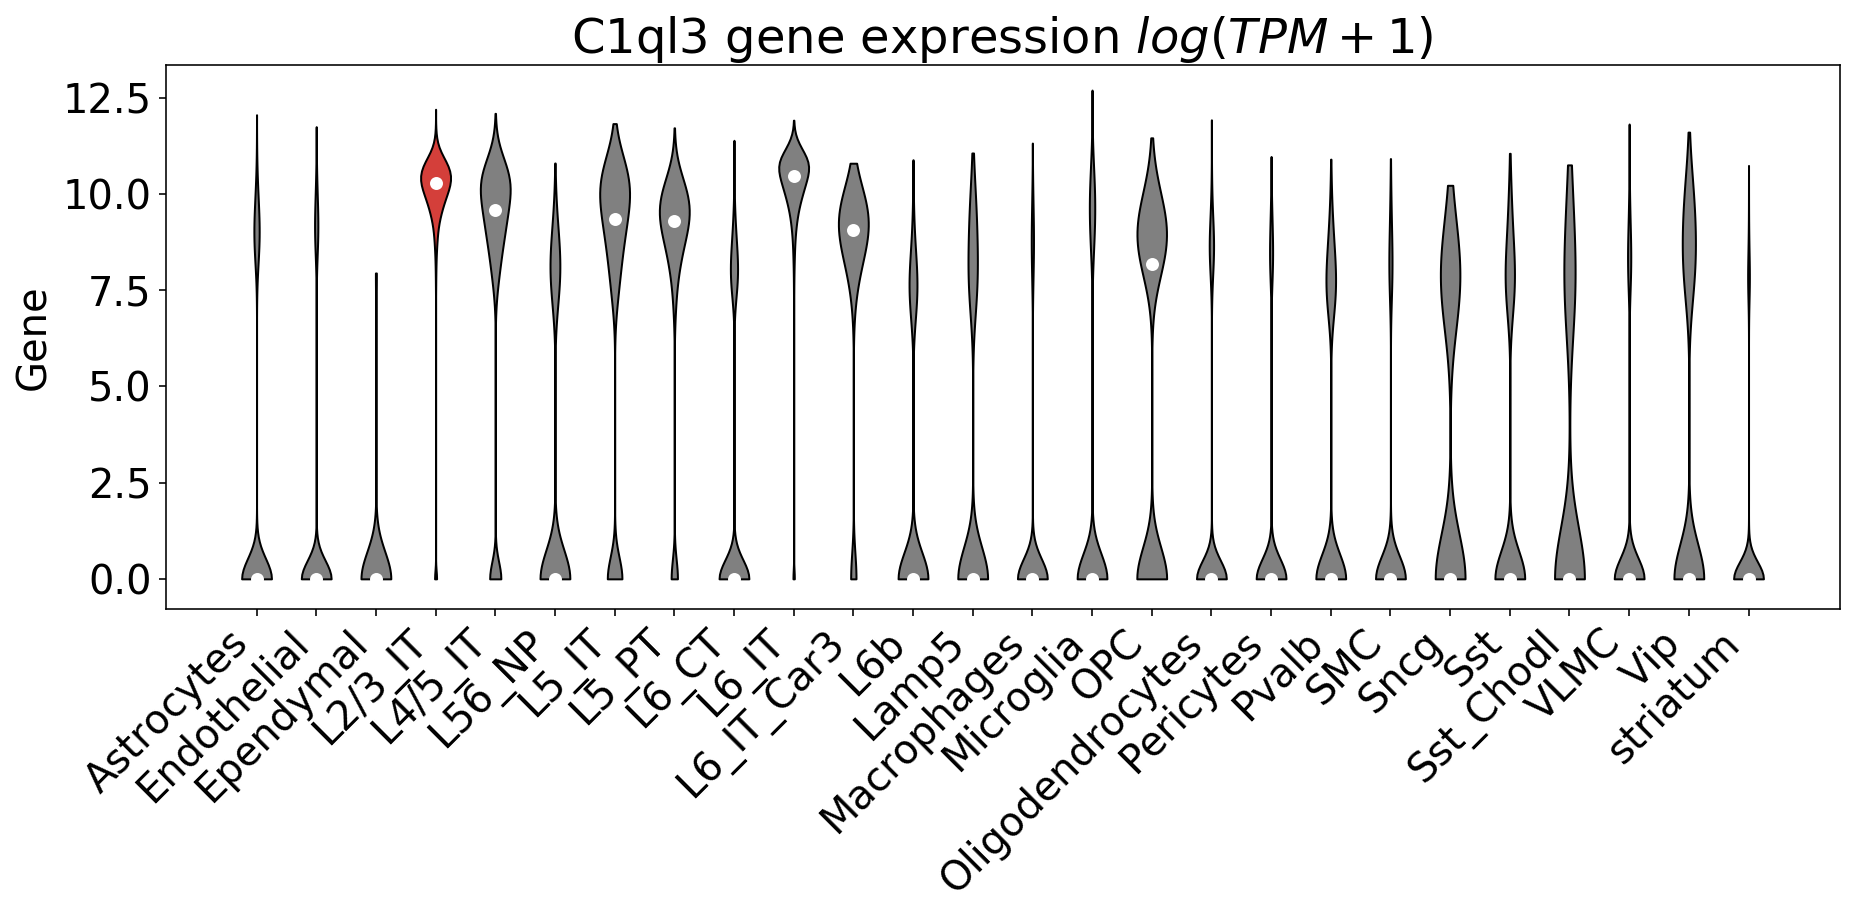

In [41]:
fig, ax = plt.subplots(figsize=(15,5))
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene.obs.subclass)


labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.subclass==c][:,gene.var.index.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax.violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

medians = [np.median(i) for i in x]
ax.scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

#ax[0].axhline(y=medians[midx], color="k", linestyle="--")
ax.set_ylabel("Gene")


medians = [np.median(i) for i in x]
ax.set_xticks(lidx)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_title("{} gene expression $log(TPM + 1)$".format(specific_gene))
#plt.savefig("./figures/class_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [42]:
identified_genes = markers_gene["gene_name"].explode().astype(str)
identified_genes = identified_genes[identified_genes!="nan"]

In [43]:
print("{} genes identified.".format(identified_genes.nunique()))

119 genes identified.


In [47]:
markers_gene["gene_name"].explode()

Astrocytes      Aqp4
Astrocytes    Cxcl14
Astrocytes     Daam2
Astrocytes    Pou3f3
Astrocytes     Timp3
               ...  
striatum       Cdh13
striatum        Penk
striatum      Pou3f3
striatum        Tac2
striatum       Calb1
Name: gene_name, Length: 431, dtype: object

In [49]:
markers_gene["p_raw"].explode()

Astrocytes              0
Astrocytes              0
Astrocytes              0
Astrocytes              0
Astrocytes              0
                 ...     
striatum                0
striatum                0
striatum       4.6813e-31
striatum      7.58643e-26
striatum      1.08276e-05
Name: p_raw, Length: 431, dtype: object

In [50]:
markers_gene = markers_gene.apply(pd.Series.explode).reset_index()

In [51]:
markers_gene

,index,gene_name,p_raw,p_bonferroni
0,Astrocytes,Aqp4,0,0
1,Astrocytes,Cxcl14,0,0
2,Astrocytes,Daam2,0,0
3,Astrocytes,Pou3f3,0,0
4,Astrocytes,Timp3,0,0
...,...,...,...,...
426,striatum,Cdh13,0,0
427,striatum,Penk,0,0
428,striatum,Pou3f3,4.6813e-31,5.94526e-29
429,striatum,Tac2,7.58643e-26,9.63476e-24


In [52]:
%%time
mtx = gene.layers["log1p"].todense()
markers_gene["mean_log1p"] = markers_gene.gene_name.apply(lambda x: mtx[:,gene.var.index.values==x].mean())

CPU times: user 1.41 s, sys: 290 ms, total: 1.7 s
Wall time: 1.7 s


In [54]:
%%time
mtx = gene.layers["norm"]
markers_gene["mean_norm"] = markers_gene.gene_name.apply(lambda x: mtx[:,gene.var.index.values==x].mean())

CPU times: user 354 ms, sys: 142 ms, total: 496 ms
Wall time: 495 ms


In [57]:
markers_gene.to_csv("tables/merfish_DE.csv")

In [56]:
markers_gene

,index,gene_name,p_raw,p_bonferroni,mean_log1p,mean_norm
0,Astrocytes,Aqp4,0,0,4.221101,10383.038046
1,Astrocytes,Cxcl14,0,0,5.064552,10335.149866
2,Astrocytes,Daam2,0,0,4.587045,12779.296338
3,Astrocytes,Pou3f3,0,0,8.140773,22706.056325
4,Astrocytes,Timp3,0,0,4.911272,14354.259676
...,...,...,...,...,...,...
426,striatum,Cdh13,0,0,4.070673,7835.282742
427,striatum,Penk,0,0,6.170283,1135.986996
428,striatum,Pou3f3,4.6813e-31,5.94526e-29,8.140773,22706.056325
429,striatum,Tac2,7.58643e-26,9.63476e-24,6.684355,1421.670474
